In [162]:
import glob 
import pandas as pd 
import tqdm 
import datetime
import numpy as np

In [163]:
stations = pd.read_excel('data/Metadane - stacje i stanowiska pomiarowe.xlsx')

In [164]:
stations = stations.rename({'Kod stacji': 'station_code', 
                            'Stary Kod stacji': 'old_station_code',
                            'WGS84 φ N': 'lat', 
                            'WGS84 λ E':'lng'}, axis=1)\
    [['station_code', 'old_station_code', 'lat', 'lng']]

In [165]:
stations_codes_unique = set(stations['station_code'].to_list() + stations['old_station_code'].to_list())

In [166]:
stations['station_id'] = range(len(stations))

In [167]:
stations_code_to_id = dict(zip(stations['station_code'], stations['station_id']))
stations_code_to_id.update(dict(zip(stations['old_station_code'], stations['station_id'])))

In [173]:
def process_df(df):
    if df.columns[0] == 'Nr': 
        time_col_first_value = 'Kod stanowiska'
        time_col_name = 'Nr'
    elif df.values[0, 0] != df.values[0, 0]: 
        time_col_first_value = 'Czas pomiaru'
        time_col_name = 'Unnamed: 0'
    else: 
        time_col_first_value = 'Czas uśredniania'
        time_col_name = 'Kod stacji'

    try: 
        df = df.rename({time_col_name: 'time'}, axis=1)
        mask = df['time'] == time_col_first_value
        if not mask.any(): 
            print(f"No '{time_col_first_value}' in df['time'] - skipped: {file}")
        second_col = df.columns[1]
        if (isinstance(second_col, str) and second_col.isdigit()) or (isinstance(second_col, int) and df.columns[1] == 1): 
            df.columns = [df.columns[0]] + list(df.values[0, 1:])
        first_row = mask.argmax() + 1
        df = df[['time'] + [col for col in df.columns if col in stations_codes_unique]].iloc[first_row:]
    except KeyError:
        print(f'KeyError - skipped: {file}')
        return 
    df = df.melt(id_vars=['time'], var_name='station_code', value_name=particle)
    return df

In [174]:
particles = ['NO2', 'O3', 'PM10', 'PM25']
data = []
files = []

for particle in particles:
    files = glob.glob(f'data/*{particle}*1g*')
    if particle == 'PM25': 
        files += glob.glob(f'data/*PM2.5*1g*')
    for file in tqdm.tqdm(glob.glob(f'data/*{particle}*1g*')): 
        df = pd.read_excel(file)
        df = process_df(df)
        if df is None: 
            continue
        if df.empty: 
            print(f"Empty df file - {file}")
        data.append(df)

 64%|████████████████████████████████████████████████████▏                             | 14/22 [02:21<01:48, 13.53s/it]c:\users\krystian kurek\.conda\envs\nlp\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
 64%|████████████████████████████████████████████████████▏                             | 14/22 [01:20<01:00,  7.61s/it]c:\users\krystian kurek\.conda\envs\nlp\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
 58%|███████████████████████████████████████████████▍                                  | 11/19 [01:39<01:16,  9.61s/it]c:\users\krystian kurek\.conda\envs\nlp\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse

In [175]:
data = pd.concat(data)

In [176]:
data_core = data[['time', 'station_code']].drop_duplicates()

In [177]:
for particle in particles: 
    data_core = data_core.merge(data[['time', 'station_code', particle]].drop_duplicates().dropna(), how='left')
data = data_core
del data_core

In [178]:
data.count()

time            19058688
station_code    19058688
NO2             14066798
O3               8678028
PM10            12518348
PM25             3028802
dtype: int64

In [179]:
def fix_time(time_to_fix): 
    dt_time_to_fix = datetime.datetime.utcfromtimestamp(time_to_fix.tolist() / 1e9)
    if dt_time_to_fix.minute <= 30:
        dt_time_to_fix = dt_time_to_fix.replace(minute=0, second=0, microsecond=0)
    else: 
        print(dt_time_to_fix)
        dt_time_to_fix = dt_time_to_fix.replace(hour=dt_time_to_fix.hour+1, minute=0, second=0, microsecond=0) 
    return np.datetime64(dt_time_to_fix)
data['time'].values[-1], fix_time(data['time'].values[-1])

(numpy.datetime64('2022-01-01T00:00:00.000000000'),
 numpy.datetime64('2022-01-01T00:00:00.000000'))

In [180]:
data['fixed_time'] = [fix_time(time_) for time_ in data['time'].values]

In [182]:
data['fixed_time'].max()

Timestamp('2022-01-01 00:00:00')

<AxesSubplot:>

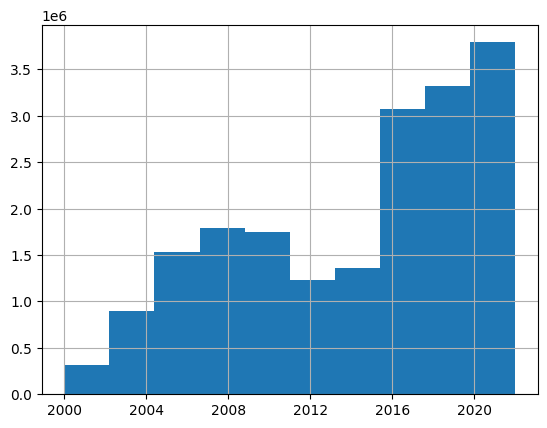

In [183]:
data['fixed_time'].hist()

In [184]:
data['time'] = data['fixed_time']

In [186]:
data = data.drop(['fixed_time'], axis=1)

In [187]:
data['time_unix'] = data['time'].values.astype('datetime64[s]').astype('int')

In [188]:
data['time_unix_plus_1h'] = data['time_unix'] + 3600

In [189]:
data = data.loc[~data[particles].isnull().all(axis=1)]

In [190]:
data = data.drop(['time'], axis=1)

In [191]:
data = data.drop('time_unix_plus_1h', axis=1)\
    .merge(data.drop('time_unix', axis=1), left_on=['time_unix', 'station_code'], right_on=['time_unix_plus_1h', 'station_code'],
          suffixes=('_present', '_future'))

In [192]:
data = data.loc[~data[[f'{particle}_future' for particle in particles]].isnull().all(axis=1)]

In [193]:
for particle in particles: 
    print(f"Particle: {particle} rows: ", data[[f'{particle}_present', f'{particle}_future']].isnull().all(axis=1).sum())

Particle: NO2 rows:  3611898
Particle: O3 rows:  9047492
Particle: PM10 rows:  5203466
Particle: PM25 rows:  14710688


In [194]:
data['station_id'] = data['station_code'].map(stations_code_to_id)

In [195]:
data = data.merge(stations[['lat','lng','station_id']])\
    .drop(['station_code', 'station_id'], axis=1)

In [212]:
for col in data.columns[:4].tolist() + data.columns[5:9].tolist():
    data[col] = data[col].apply(lambda x: x.replace(',', '.') if isinstance(x, str) else x).apply(float)

In [213]:
data.to_feather('air_data.feather')